In [2]:
%pylab inline
import sys
sys.path.append("/mnt/home/ecunningham/python")
plt.style.use('~/matplotlib.mplstyle')
#import io_sims as ios
import gizmo_analysis as ga
import pynbody
import halo_analysis as halo
from pynbody import filt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [26]:
plt.rcParams['text.usetex'] = False

In [3]:
sim_directory = "/mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/"


In [4]:
snap = 385

In [6]:
p = ga.io.Read.read_snapshots(['dark', 'star'], 'index', snap, sim_directory, 
                              assign_hosts=True, particle_subsample_factor=10)


# in utilities.simulation.Snapshot():
* reading:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/snapshot_times.txt

  using snapshot index = 385, redshift = 0.488


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/output/snapdir_385/snapshot_385.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 74537000 particles
    dark2     (id = 2): 6750970 particles
    gas       (id = 0): 64162001 particles
    star      (id = 4): 10869964 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['dark', 'star']

* reading particles from:
    snapshot_385.0.hdf5
    snapshot_385.1.hdf5
    snapshot_385.2.hdf5
    snapshot_385.3.hdf5
    snapshot_385.4.hdf5
    snapshot_385.5.hdf5
    snapshot_385.6.hdf5
    snapshot_385.7.hdf5

* reading cosmological parameters from:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/initial_condition/ic_agora_m12b.conf

* perio

In [7]:
def pynbody_halo(particles):

    ndark = len(particles['dark']['mass'])
    nstar = len(particles['star']['mass'])
    halo_pynb = pynbody.new(dark=int(ndark), star=int(nstar), order='dark,star')
    halo_pynb.dark['pos'] = particles['dark'].prop('host.distance')
    halo_pynb.dark['vel'] = particles['dark'].prop('host.velocity')
    halo_pynb.dark['mass'] = particles['dark'].prop('mass')

    halo_pynb.star['pos'] = particles['star'].prop('host.distance')
    halo_pynb.star['vel'] = particles['star'].prop('host.velocity')
    halo_pynb.star['mass'] = particles['star'].prop('mass')
    halo_pynb.dark['pos'].units = 'kpc'
    halo_pynb.dark['vel'].units = 'km s**-1'
    halo_pynb.dark['mass'].units = '1e10 Msol'

    halo_pynb.star['pos'].units = 'kpc'
    halo_pynb.star['vel'].units = 'km s**-1'
    halo_pynb.star['mass'].units = '1e10 Msol'
    
    return halo_pynb

def pynbody_subhalos(particles):

    sub_stars = particles['star.number']
    stars = np.where(sub_stars!=-1)
    ndark = len(particles['mass'])
    nstar = len(particles['mass'][stars])
    halo_pynb = pynbody.new(dark=int(ndark), star=int(nstar), order='dark,star')
    halo_pynb.dark['pos'] = particles['host.distance']
    halo_pynb.dark['vel'] = particles['host.velocity']
    halo_pynb.dark['mass'] = particles['mass']

    halo_pynb.star['pos'] = particles['host.distance'][stars]
    halo_pynb.star['vel'] = particles['host.velocity'][stars]
    halo_pynb.star['mass'] = particles['mass'][stars]
    halo_pynb.dark['pos'].units = 'kpc'
    halo_pynb.dark['vel'].units = 'km s**-1'
    halo_pynb.dark['mass'].units = '1e10 Msol'

    halo_pynb.star['pos'].units = 'kpc'
    halo_pynb.star['vel'].units = 'km s**-1'
    halo_pynb.star['mass'].units = '1e10 Msol'
    
    return halo_pynb

def make_pynbody_rotations(halo):
    cen = halo[filt.Sphere("5 kpc")]
    Lh = pynbody.analysis.angmom.ang_mom_vec(cen)
    Tx_faceon = pynbody.analysis.angmom.calc_faceon_matrix(Lh)
    Tx_sideon = pynbody.analysis.angmom.calc_sideon_matrix(Lh)

    return Tx_faceon, Tx_sideon

## Tracking subhalos using their index at 300th snap (using only merger tree)
def return_tracked_pos(halo_tree, tr_ind_at_ninit, ninit=300, nfinal=601, pynbody_halo=False):
    h_index = tr_ind_at_ninit
    tree_ind = []
    for _ in range(ninit, nfinal):
        tree_ind.append(h_index)
        h_index = halo_tree['descendant.index'][h_index]
    tree_ind = np.array(tree_ind)
    position = halo_tree['host.distance'][tree_ind]
    nsnaps = halo_tree['snapshot'][tree_ind]
    mass = halo_tree['mass'][tree_ind]
    velocity = halo_tree['host.velocity'][tree_ind]
    #vel_rad = halt['host.velocity.rad'][tree_ind]
    #vel_tan = halt['host.velocity.tan'][tree_ind]
    
    if pynbody_halo == True:
        ndark = nfinal-ninit
        halo_pynb = pynbody.new(dark=int(ndark))
        halo_pynb.dark['pos'] = position
        halo_pynb.dark['vel'] = velocity
        halo_pynb.dark['mass'] = mass
        halo_pynb.dark['snap'] = nsnaps
        return halo_pynb
    else :
        return {'position': position,
                'snaps' : nsnaps,
                'mass' : mass,
                'velocity' : velocity,
               }

In [8]:
h = pynbody_halo(p)

In [9]:
pynbody.analysis.angmom.faceon(h, cen=(0,0,0))

In [11]:
m12b_subhalos = halo.io.IO.read_catalogs('index', 300, sim_directory)


# in utilities.simulation.Snapshot():
* reading:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/snapshot_times.txt

  using snapshot index = 300, redshift = 0.864


# in halo_analysis.halo_io.IO():
* read 51054 halos from:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/halo/rockstar_dm/catalog_hdf5/halo_300.hdf5

# in halo_analysis.halo_io.Particle():
* read 51054 halos, 96 have star particles, from:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/halo/rockstar_dm/catalog_hdf5/star_300.hdf5
* assigning primary host and coordinates wrt it to halo catalog...  finished



In [12]:
hsub = pynbody_subhalos(m12b_subhalos)
hsub_faceon = pynbody_subhalos(m12b_subhalos)
#hsub_edgeon = pynbody_subhalos(m12b_subhalos)

# Satellite subhalos
sat_id = argsort(hsub.dark['mass'])[-2]

In [13]:
sat_tree_id = m12b_subhalos['tree.index'][sat_id]

In [14]:
halt = halo.io.IO.read_tree(simulation_directory=sim_directory)


# in utilities.simulation.Snapshot():
* reading:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/snapshot_times.txt

* read 19882039 halos from:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/halo/rockstar_dm/catalog_hdf5/tree.hdf5



In [15]:
satellite = return_tracked_pos(halt, sat_tree_id, pynbody_halo=True)

In [16]:
h_rotations = pynbody_halo(p)
faceon, edgeon = make_pynbody_rotations(h_rotations)

In [17]:
pynbody.transformation.transform(hsub_faceon, faceon)
#pynbody.transformation.transform(hsub_edgeon, edgeon)

In [18]:
satellite_faceon = satellite
#satellite_edgeon = satellite

In [19]:
pynbody.transformation.transform(satellite_faceon, faceon)
#pynbody.transformation.transform(satellite_edgeon, edgeon)

In [20]:
#np.savetxt("m12b_satellite_orbit_face_on.txt", satellite)

In [21]:
"""
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

dmproj2 = pynbody.plot.sph.faceon_image(h.s, width=320, resolution=120, cmap='inferno', subplot=ax[0], show_cbar=False)
ax[0].plot(satellite_edgeon.dark['pos'][:85,0], satellite_edgeon.dark['pos'][:85,2], c='w', ls='--', alpha=0.6, lw=1)


ax[1].plot(satellite_edgeon.dark['pos'][:85,0], satellite_edgeon.dark['pos'][:85,1], c='w', ls='--', alpha=0.6, lw=1)
dmproj2 = pynbody.plot.sph.sideon_image(h.s, width=320, resolution=120, cmap='inferno', subplot=ax[1], show_cbar=False)
"""

"\nfig, ax = plt.subplots(1, 2, figsize=(8, 4))\n\ndmproj2 = pynbody.plot.sph.faceon_image(h.s, width=320, resolution=120, cmap='inferno', subplot=ax[0], show_cbar=False)\nax[0].plot(satellite_edgeon.dark['pos'][:85,0], satellite_edgeon.dark['pos'][:85,2], c='w', ls='--', alpha=0.6, lw=1)\n\n\nax[1].plot(satellite_edgeon.dark['pos'][:85,0], satellite_edgeon.dark['pos'][:85,1], c='w', ls='--', alpha=0.6, lw=1)\ndmproj2 = pynbody.plot.sph.sideon_image(h.s, width=320, resolution=120, cmap='inferno', subplot=ax[1], show_cbar=False)\n"

In [22]:
"""
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].scatter(hsub.dark['pos'][:,0], hsub.dark['pos'][:,1], s=0.2, c='k', alpha=0.12)
ax[1].scatter(hsub.dark['pos'][:,1], hsub.dark['pos'][:,2], s=0.2, c='k', alpha=0.3)



ax[0].scatter(hsub.dark['pos'][sat_id,0], hsub.dark['pos'][sat_id,1], s=20, c='r', alpha=1)
ax[1].scatter(hsub.dark['pos'][sat_id,1], hsub.dark['pos'][sat_id,2], s=20, c='r', alpha=1)

ax[1].set_xlim(-600, 600)
ax[1].set_ylim(-600, 600)

ax[0].set_xlim(-600, 600)
ax[0].set_ylim(-600, 600)

dmproj2 = pynbody.plot.sph.side on_image(h.s, width=80, resolution=120, cmap='inferno', subplot=ax[2], show_cbar=False)
ax[2].scatter(hsub.dark['pos'][sat_id,0], hsub.dark['pos'][sat_id,2], s=20, c='r', alpha=1)
"""

"\nfig, ax = plt.subplots(1, 3, figsize=(12, 4))\nax[0].scatter(hsub.dark['pos'][:,0], hsub.dark['pos'][:,1], s=0.2, c='k', alpha=0.12)\nax[1].scatter(hsub.dark['pos'][:,1], hsub.dark['pos'][:,2], s=0.2, c='k', alpha=0.3)\n\n\n\nax[0].scatter(hsub.dark['pos'][sat_id,0], hsub.dark['pos'][sat_id,1], s=20, c='r', alpha=1)\nax[1].scatter(hsub.dark['pos'][sat_id,1], hsub.dark['pos'][sat_id,2], s=20, c='r', alpha=1)\n\nax[1].set_xlim(-600, 600)\nax[1].set_ylim(-600, 600)\n\nax[0].set_xlim(-600, 600)\nax[0].set_ylim(-600, 600)\n\ndmproj2 = pynbody.plot.sph.side on_image(h.s, width=80, resolution=120, cmap='inferno', subplot=ax[2], show_cbar=False)\nax[2].scatter(hsub.dark['pos'][sat_id,0], hsub.dark['pos'][sat_id,2], s=20, c='r', alpha=1)\n"

In [23]:
satellite_faceon.dark['pos'][76]

SimArray([ 47.05518012,   1.51000596, -58.31052308])

In [24]:

times = '/mnt/ceph/users/firesims/fire2/metaldiff/{}_res7100/snapshot_times.txt'.format('m12b')
t_snap = np.loadtxt(times, usecols=3)

fig, ax = plt.subplots(2, 3, figsize=(20, 13))
dmproj = pynbody.plot.image(h.d, width=1200, cmap='Greys', subplot=ax[0][0], show_cbar=False, av_z=True)
dmproj2 = pynbody.plot.sph.sideon_image(h.d, width=600, cmap='Greys', subplot=ax[1][0], show_cbar=False, av_z=True)

dmproj = pynbody.plot.image(h.s, width=300, resolution=120, cmap='inferno', subplot=ax[0][1], show_cbar=False, av_z=True)
dmproj2 = pynbody.plot.sph.sideon_image(h.s, width=300, resolution=120, cmap='inferno', subplot=ax[1][1], show_cbar=False, av_z=True)

dmproj = pynbody.plot.image(h.s, width=100, resolution=120, cmap='inferno', subplot=ax[0][2], show_cbar=False, av_z=True)
dmproj2 = pynbody.plot.sph.sideon_image(h.s, width=100, resolution=120, cmap='inferno', subplot=ax[1][2], show_cbar=False, av_z=True)


ax[0][0].plot(satellite_faceon.dark['pos'][:76,0], satellite_faceon.dark['pos'][:76,1], c='k', ls='--', alpha=0.6, lw=1)
ax[1][0].plot(satellite_faceon.dark['pos'][:76,0], satellite_faceon.dark['pos'][:76,2], c='k', ls='--', alpha=0.6, lw=1)

ax[0][1].plot(satellite_faceon.dark['pos'][:76,0], satellite_faceon.dark['pos'][:76,1], c='w', ls='--', alpha=0.6, lw=1)
ax[1][1].plot(satellite_faceon.dark['pos'][:76,0], satellite_faceon.dark['pos'][:76,2], c='w', ls='--', alpha=0.6, lw=1)

ax[0][2].plot(satellite_faceon.dark['pos'][:76,0], satellite_faceon.dark['pos'][:76,1], c='w', ls='--', alpha=0.6, lw=1)
ax[1][2].plot(satellite_faceon.dark['pos'][:76,0], satellite_faceon.dark['pos'][:76,2], c='w', ls='--', alpha=0.6, lw=1)



ax[0][1].set_ylabel('')
ax[0][2].set_ylabel('')
ax[1][1].set_ylabel('')
ax[1][2].set_ylabel('')

ax[0][0].set_xlabel('$x\mathrm{[kpc]}$')
ax[0][1].set_xlabel('$x\mathrm{[kpc]}$')
ax[0][2].set_xlabel('$x\mathrm{[kpc]}$')

ax[1][0].set_xlabel('$x\mathrm{[kpc]}$')
ax[1][1].set_xlabel('$x\mathrm{[kpc]}$')
ax[1][2].set_xlabel('$x\mathrm{[kpc]}$')


ax[0][0].set_ylabel('$y\mathrm{[kpc]}$')
ax[1][0].set_ylabel('$z\mathrm{[kpc]}$')

ax[0][0].set_title('$\mathrm{Dark\ Matter}$', fontsize=16)
ax[0][1].set_title('$\mathrm{Stars\ outer\ halo}$', fontsize=16)
ax[0][2].set_title('$\mathrm{Stars\ inner\ halo}$', fontsize=16)
fig.suptitle('$t={:.2f}$'.format(t_snap[snap]) + r' $\rm{Gyr;}\ \rm{Sim:\ m12b}$', fontsize=18, y=0.95)

ax[0][0].text(-500, 400, r"$\rm{Face-on}$", c='w', fontsize=20)
ax[0][0].text(-500, 400, r"$\rm{Face-on}$", c='k', fontsize=18)
ax[1][0].text(-500, 400, r"$\rm{Edge-on}$", c='k', fontsize=18)

ax[0][0].set_xlim(-600, 600)
ax[1][0].set_xlim(-300, 300)

ax[0][1].set_xlim(-150, 150)
ax[1][1].set_xlim(-150, 150)

ax[0][2].set_xlim(-50, 50)
ax[1][2].set_xlim(-50, 50)

ax[0][0].set_ylim(-600, 600)
ax[1][0].set_ylim(-300, 300)

ax[0][1].set_ylim(-150, 150)
ax[1][1].set_ylim(-150, 150)

ax[0][2].set_ylim(-50, 50)
ax[1][2].set_ylim(-50, 50)

FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss12.tfm' in your texmf tree, but could not find it

FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss12.tfm' in your texmf tree, but could not find it

<Figure size 2000x1300 with 6 Axes>

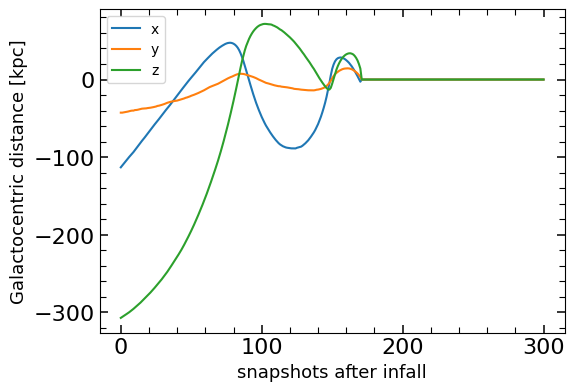

In [34]:
plt.plot(satellite_faceon.dark['pos'][:,0], label='x')
plt.plot(satellite_faceon.dark['pos'][:,1], label='y')
plt.plot(satellite_faceon.dark['pos'][:,2], label='z')
plt.legend()
plt.xlabel('snapshots after infall', fontsize=13)
plt.ylabel('Galactocentric distance [kpc]', fontsize=13)
plt.savefig('satellite_orbit_xyz.png', bbox_inches='tight')

In [25]:
pynbody.plot.image?

Signature:
pynbody.plot.image(
    sim,
    qty='rho',
    width='10 kpc',
    resolution=500,
    units=None,
    log=True,
    vmin=None,
    vmax=None,
    av_z=False,
    filename=None,
    z_camera=None,
    clear=True,
    cmap=None,
    title=None,
    qtytitle=None,
    show_cbar=True,
    subplot=False,
    noplot=False,
    ret_im=False,
    fill_nan=True,
    fill_val=0.0,
    linthresh=None,
    **kwargs,
)
Docstring:
Make an SPH image of the given simulation.

**Keyword arguments:**

*qty* (rho): The name of the array to interpolate

*width* (10 kpc): The overall width and height of the plot. If
 ``width`` is a float or an int, then it is assumed to be in units
 of ``sim['pos']``. It can also be passed in as a string
 indicating the units, i.e. '10 kpc', in which case it is
 converted to units of ``sim['pos']``.

*resolution* (500): The number of pixels wide and tall

*units* (None): The units of the output

*av_z* (False): If True, the requested quantity is averaged down


(-50.0, 50.0)

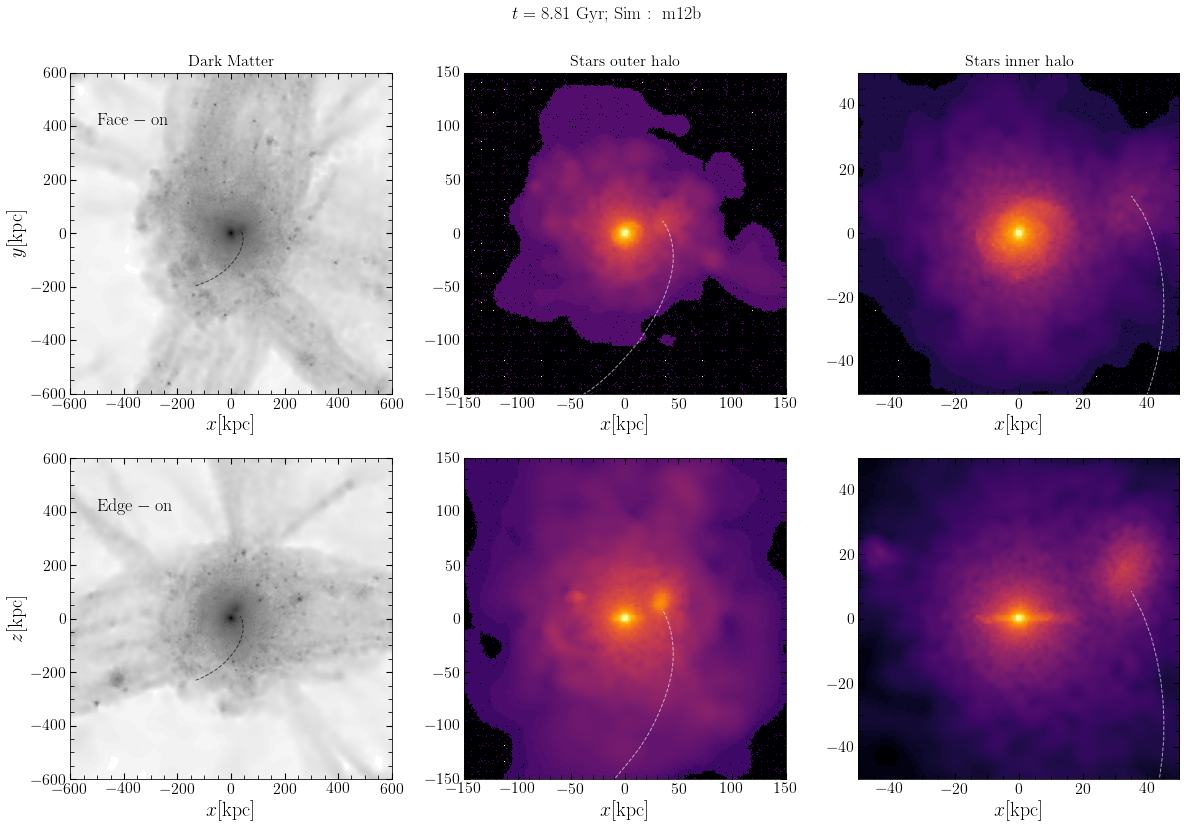

In [51]:
# Add time legend


#def plot_

times = '/mnt/ceph/users/firesims/fire2/metaldiff/{}_res7100/snapshot_times.txt'.format('m12b')
t_snap = np.loadtxt(times, usecols=3)

fig, ax = plt.subplots(2, 3, figsize=(20, 13))
dmproj = pynbody.plot.image(h.d, width=1200, cmap='Greys', subplot=ax[0][0], show_cbar=False)
dmproj2 = pynbody.plot.sph.sideon_image(h.d, width=1200, cmap='Greys', subplot=ax[1][0], show_cbar=False)

dmproj = pynbody.plot.image(h.s, width=300, resolution=120, cmap='inferno', subplot=ax[0][1], show_cbar=False)
dmproj2 = pynbody.plot.sph.sideon_image(h.s, width=300, resolution=120, cmap='inferno', subplot=ax[1][1], show_cbar=False)

dmproj = pynbody.plot.image(h.s, width=100, resolution=120, cmap='inferno', subplot=ax[0][2], show_cbar=False)
dmproj2 = pynbody.plot.sph.sideon_image(h.s, width=100, resolution=120, cmap='inferno', subplot=ax[1][2], show_cbar=False)


ax[0][0].plot(satellite_faceon.dark['pos'][:86,0], satellite_faceon.dark['pos'][:86,1], c='k', ls='--', alpha=0.6, lw=1)
ax[1][0].plot(satellite_faceon.dark['pos'][:86,0], satellite_faceon.dark['pos'][:86,2], c='k', ls='--', alpha=0.6, lw=1)


ax[0][1].plot(satellite_faceon.dark['pos'][:86,0], satellite_faceon.dark['pos'][:86,1], c='w', ls='--', alpha=0.6, lw=1)
ax[1][1].plot(satellite_faceon.dark['pos'][:86,0], satellite_faceon.dark['pos'][:86,2], c='w', ls='--', alpha=0.6, lw=1)

ax[0][2].plot(satellite_faceon.dark['pos'][:86,0], satellite_faceon.dark['pos'][:86,1], c='w', ls='--', alpha=0.6, lw=1)
ax[1][2].plot(satellite_faceon.dark['pos'][:86,0], satellite_faceon.dark['pos'][:86,2], c='w', ls='--', alpha=0.6, lw=1)



ax[0][1].set_ylabel('')
ax[0][2].set_ylabel('')
ax[1][1].set_ylabel('')
ax[1][2].set_ylabel('')

ax[0][0].set_xlabel('$x\mathrm{[kpc]}$')
ax[0][1].set_xlabel('$x\mathrm{[kpc]}$')
ax[0][2].set_xlabel('$x\mathrm{[kpc]}$')

ax[1][0].set_xlabel('$x\mathrm{[kpc]}$')
ax[1][1].set_xlabel('$x\mathrm{[kpc]}$')
ax[1][2].set_xlabel('$x\mathrm{[kpc]}$')


ax[0][0].set_ylabel('$y\mathrm{[kpc]}$')
ax[1][0].set_ylabel('$z\mathrm{[kpc]}$')

ax[0][0].set_title('$\mathrm{Dark\ Matter}$', fontsize=16)
ax[0][1].set_title('$\mathrm{Stars\ outer\ halo}$', fontsize=16)
ax[0][2].set_title('$\mathrm{Stars\ inner\ halo}$', fontsize=16)
fig.suptitle('$t={:.2f}$'.format(t_snap[snap]) + r' $\rm{Gyr;}\ \rm{Sim:\ m12b}$', fontsize=18, y=0.95)

ax[0][0].text(-500, 400, r"$\rm{Face-on}$", c='k', fontsize=18)
ax[1][0].text(-500, 400, r"$\rm{Edge-on}$", c='k', fontsize=18)

ax[0][0].set_xlim(-600, 600)
ax[1][0].set_xlim(-600, 600)

ax[0][1].set_xlim(-150, 150)
ax[1][1].set_xlim(-150, 150)

ax[0][2].set_xlim(-50, 50)
ax[1][2].set_xlim(-50, 50)


ax[0][0].set_ylim(-600, 600)
ax[1][0].set_ylim(-600, 600)

ax[0][1].set_ylim(-150, 150)
ax[1][1].set_ylim(-150, 150)

ax[0][2].set_ylim(-50, 50)
ax[1][2].set_ylim(-50, 50)

In [ ]:
# TODO use pynbody halo format to apply the rotation to any vector you desired to rotate! 